<a href="https://colab.research.google.com/github/Frorozcoloa/FinancIA/blob/main/Notebooks/0-2%20Train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenamiento e inferencia del modelo

In [ ]:
%%capture
!pip install transformers wandb torchmetrics lightning

Instalamos las librerias que se neceista para el entrenamiento

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import wandb
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import set_seed
from torch import nn

def SEED(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    set_seed(seed)


SEED(42)


# Configuration by model
NUM_VARAIBLES = 3
NUM_LABELS = 3
num_labels = NUM_LABELS * NUM_VARAIBLES
divice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Importamos las librerias necesarias y fijamos las semillas para iniciar el entrenamiento

## Modelo pre-entrenado

Se va hacer fine-tuning al modelo de robertuito, uno de los modelos que representa el estado del arte en la detección de sentimientos en epañol. El cambio que vamos hacer es de multilabel, al final el modelo va a retornar un vector de 9 posiciones. Donde cada una nos dice la probabilidad o incertidumbre de pertenecer a esa etiqueta.

In [3]:
from transformers import ( 
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_constant_schedule_with_warmup,
)

# Configuring the model
num_labels = NUM_LABELS * NUM_VARAIBLES
model_name = "pysentimiento/robertuito-sentiment-analysis"
auto_tokenizer = AutoTokenizer.from_pretrained(model_name)
model_hugginface = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, ignore_mismatched_sizes=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenizador.

Como primera medida es importante instranciar el tokenizador

In [4]:
a = auto_tokenizer("hola", return_tensors="pt" )
a

{'input_ids': tensor([[   0, 1878,    2]]), 'token_type_ids': tensor([[0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1]])}

### Modelo pre-entrenado

Instanciamos el modelo de hugginface y mostramos su funcionamiento.

In [5]:
model_hugginface(a["input_ids"], a["attention_mask"], a["token_type_ids"]).logits

tensor([[-0.0134,  0.0390,  0.2664, -0.0361, -0.2827,  0.1921, -0.1001, -0.0453,
         -0.1583]], grad_fn=<AddmmBackward0>)

### Clase FinanciaSentimental

Creamos las clase FinanciaSentimental que hereda de Dataset, donde se cargarán los datos para entrenar el mdoelo. Importante ver que el texto va a pasar por el tokenizador y las etiquetas se convierte a tensor.

In [6]:
class FinanciaSentimental(Dataset):
    """This class is used to load the data and tokenize it"""
    def __init__(self, tokenizer, dataframe, columns, max_len=512):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        ## Columns to target
        self._columns = columns
        self.max_len = max_len
    
    @property
    def columns(self):
        """Return the columns to target"""
        return self._columns

    def __len__(self):
        """Return the length of the dataset"""
        return len(self.dataframe)
        
    def __getitem__(self, index):
        """Get the data at the index"""
        values = self.dataframe.iloc[index]
        text = values['text']
        label = values[self._columns].values.astype(np.float32)
        inputs = self.tokenizer.encode_plus(text, max_length=130, pad_to_max_length=True, padding='max_length', truncation=True, return_tensors='pt')
        label = torch.tensor(label, dtype=torch.float)
        input_ids = inputs["input_ids"].squeeze().to(dtype=torch.long)
        attention_mask = inputs["attention_mask"].squeeze().to(dtype=torch.long)
        token_type_ids = inputs["token_type_ids"].squeeze().to(dtype=torch.long)
        
        inputs_dict = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_ids,
            "labels":label
        }

        return inputs_dict

### Clase de entrenamiento

Usando lalibrería lightning, creamos el modelo y la lógica de entrenamiento.Se uso el optimizador Adamw, y un schuler donde a medida que se acerque al objectivo, la función reducirá su lr.

In [7]:
import torch
import lightning.pytorch as pl
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
from torch.nn import BCEWithLogitsLoss

class FinanciaMultilabel(pl.LightningModule):
    
    def __init__(self, model, num_labels):
        super().__init__()
        self.model = model
        self.num_labels = num_labels
        self.loss = BCEWithLogitsLoss()
        self.validation_step_outputs = []

    def forward(self, input_ids, attention_mask, token_type_ids):
        return self.model(input_ids, attention_mask, token_type_ids).logits

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        token_type_ids = batch["token_type_ids"]
        outputs = self(input_ids, attention_mask, token_type_ids)
        loss = self.loss(outputs.view(-1,self.num_labels), labels.type_as(outputs).view(-1,self.num_labels))
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        token_type_ids = batch["token_type_ids"]
        outputs = self(input_ids, attention_mask, token_type_ids)
        loss = self.loss(outputs.view(-1,self.num_labels), labels.type_as(outputs).view(-1,self.num_labels))
        pred_labels = torch.sigmoid(outputs)
        info = {'val_loss': loss, 'pred_labels': pred_labels, 'labels': labels}
        self.validation_step_outputs.append(info)
        return 

    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        pred_labels = torch.cat([x['pred_labels'] for x in outputs])
        labels = torch.cat([x['labels'] for x in outputs])
        threshold = 0.50
        pred_bools = pred_labels > threshold
        true_bools = labels == 1
        val_f1_accuracy = f1_score(true_bools.cpu(), pred_bools.cpu(), average='micro')*100
        val_flat_accuracy = accuracy_score(true_bools.cpu(), pred_bools.cpu())*100
        self.log('val_loss', avg_loss)
        self.log('val_f1_accuracy', val_f1_accuracy, prog_bar=True)
        self.log('val_flat_accuracy', val_flat_accuracy, prog_bar=True)
        self.validation_step_outputs.clear() 

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True, min_lr=1e-6)
        return {
                'optimizer': optimizer,
                'lr_scheduler': {
                    'scheduler': scheduler,
                    'monitor': 'val_loss'
                }
            }

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Cargamos el dataset en pandas

In [9]:
train_df = "/content/drive/Shareddrives/Redes neuronales/Datasets/df_with_sentiment.csv"
df = pd.read_csv(train_df)
df = df[["id",	"text",	"target",	"target_sentiment",	"companies_sentiment",	"consumers_sentiment", "tag"]]
df = pd.get_dummies(df, columns = ["target_sentiment",	"companies_sentiment","consumers_sentiment"])
df_train = df[df.tag == "train"]
df_test = df[df.tag == "test"]
df_valid, df_test = train_test_split(df_test, test_size=0.5)

In [10]:
df_valid

,id,text,target,tag,target_sentiment_negative,target_sentiment_neutral,target_sentiment_positive,companies_sentiment_negative,companies_sentiment_neutral,companies_sentiment_positive,consumers_sentiment_negative,consumers_sentiment_neutral,consumers_sentiment_positive
820,80591,La UE advierte de las consecuencias económicas...,UE,test,1,0,0,1,0,0,1,0,0
775,72293,Empieza el juicio por los 500 seísmos que caus...,Castor,test,1,0,0,0,1,0,1,0,0
830,99766,Los ‘nuevos’ ERTE mantienen la prohibición de ...,ERTE,test,0,0,1,1,0,0,0,0,1
822,40165,Cellnex salta mañana al cuarto puesto por capi...,Cellnex,test,0,0,1,1,0,0,0,1,0
848,32667,"Stripe, el mayor 'unicornio' de Silicon Valley...",Stripe,test,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,7312,Así evoluciona el precio de la vivienda usada,precio de vivienda usada,test,0,1,0,0,1,0,0,1,0
842,25376,Santander aprueba la salida a Bolsa de Getnet ...,Santander,test,0,0,1,0,1,0,0,1,0
750,67465,Calviño aboga por retrasar la reforma fiscal h...,Calviño,test,0,0,1,0,1,0,1,0,0
828,310714,El consejo de Norwegian rechaza las dos oferta...,Norwegian,test,0,0,1,1,0,0,0,1,0


In [11]:
columns_varaibles = ["target_sentiment_negative",	"target_sentiment_neutral",	"target_sentiment_positive"	,"companies_sentiment_negative"	,"companies_sentiment_neutral",	"companies_sentiment_positive", 'consumers_sentiment_negative',
       'consumers_sentiment_neutral', 'consumers_sentiment_positive']

In [12]:
print(df.shape)
print(df_train.shape)

(905, 13)
(736, 13)


## Entrenamiento

Lo primero es instanciar los dataset y crear los dataloader con batch_size = 16

In [13]:
train_dataset = FinanciaSentimental(auto_tokenizer, df_train, columns_varaibles)
valid_dataset = FinanciaSentimental(auto_tokenizer, df_valid, columns_varaibles)
test_dataset = FinanciaSentimental(auto_tokenizer, df_test, columns_varaibles)

In [14]:
inputs = next(iter(train_dataset))
print(inputs.keys())

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels'])


In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [16]:
inputs = next(iter(train_dataloader))
print(inputs.keys())


dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels'])


### Registro de las métricas

Todas las métricas se llevan un registro en wandb, para comparar los modelos

In [17]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(project='FinancIA', name='#1', save_code=True, log_model=False, sync_tensorboard=True, save_dir="./logs")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: WARNING Path ./logs/wandb/ wasn't writable, using system temp directory.


### Entrenamiento

Realizamos el respectivo entrenameinto del modelo. Se va a guardar el ultimo epoch y el que tenga la mejor
métricas

In [18]:
from  lightning.pytorch import Trainer
from  lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from  lightning.pytorch.callbacks.progress import TQDMProgressBar
from  lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader, WeightedRandomSampler

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="max", save_last=True, save_weights_only=True)
tqdm_callback = TQDMProgressBar(refresh_rate=1)
trainer = pl.Trainer( accelerator="cuda", max_epochs=10, logger=wandb_logger, callbacks=[checkpoint_callback, tqdm_callback], precision=16,)
model = FinanciaMultilabel(model_hugginface,9)
wandb_logger.watch(model, log="all")
trainer.fit(model,train_dataloader,  valid_dataloader)

/usr/local/lib/python3.10/dist-packages/lightning/fabric/connector.py:555: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | RobertaForSequenceClassification | 

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [19]:
!zip -r logs.zip logs

  adding: logs/ (stored 0%)
  adding: logs/wandb/ (stored 0%)
  adding: logs/FinancIA/ (stored 0%)
  adding: logs/FinancIA/1y2tfqnr/ (stored 0%)
  adding: logs/FinancIA/1y2tfqnr/checkpoints/ (stored 0%)
  adding: logs/FinancIA/1y2tfqnr/checkpoints/last.ckpt (deflated 7%)
  adding: logs/FinancIA/1y2tfqnr/checkpoints/epoch=7-step=368.ckpt (deflated 7%)


## Inferencia del modelo
Cargamos el mdoelo con las mejores métricas.

In [31]:
device = "cuda"
model = FinanciaMultilabel.load_from_checkpoint(
        "/content/logs/FinancIA/1y2tfqnr/checkpoints/epoch=7-step=368.ckpt",
        model=model_hugginface,
        num_labels=num_labels,
        map_location=device
    )

Cargamos las 9 etiquetas de neustro mdoelo.

In [45]:
RETURN_VALUES = [
    "target_sentiment_negative",
    "target_sentiment_neutral",
    "target_sentiment_positive",
    "companies_sentiment_negative",
    "companies_sentiment_neutral",
    "companies_sentiment_positive",
    "consumers_sentiment_negative",
    "consumers_sentiment_neutral",
    "consumers_sentiment_positive"
]

### Modulo de testeo

Corremos y gaurdamos las métricas para el módulo de testo

In [33]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
model.eval()
device = "cuda"
# Paso 3: procesar los datos de entrada y obtener las predicciones
all_preds = []
labels = []
with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids = batch["input_ids"].to(device)
        b_input_mask = batch["attention_mask"].to(device)
        b_labels = batch["labels"]
        token_type_ids = batch["token_type_ids"]
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        preds = torch.sigmoid(outputs).detach().cpu().numpy()
        labels.append(b_labels.numpy())
        all_preds.append(preds)

# Paso 4: procesar las predicciones
all_preds = np.concatenate(all_preds)
binary_preds = (all_preds > 0.5).astype(int)

# Paso 5: evaluar el rendimiento del modelo
test_labels = np.concatenate(labels)

Imprimimos el reporte, donde podemos ver que en general al modelo le es complejo predicir las etiquetas neutrales. PEro en general se obtiene un f1-score de 60%, no muy buena métrica pero si lo suficiente para tener un dataset inicial e ir aumentando a medida que salgan más noticias.

In [46]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
print(classification_report(test_labels, binary_preds, target_names=RETURN_VALUES))

                              precision    recall  f1-score   support

   target_sentiment_negative       0.60      0.96      0.74        27
    target_sentiment_neutral       0.50      0.50      0.50         4
   target_sentiment_positive       0.91      0.59      0.72        54
companies_sentiment_negative       0.56      0.54      0.55        28
 companies_sentiment_neutral       0.57      0.50      0.53        40
companies_sentiment_positive       0.71      0.29      0.42        17
consumers_sentiment_negative       0.59      0.59      0.59        17
 consumers_sentiment_neutral       0.74      0.81      0.77        48
consumers_sentiment_positive       0.61      0.55      0.58        20

                   micro avg       0.67      0.63      0.65       255
                   macro avg       0.64      0.59      0.60       255
                weighted avg       0.69      0.63      0.64       255
                 samples avg       0.68      0.63      0.65       255



### Matrices de confunción
DOnde las filas son la etiqueta verdera, y las columnas son las predichas por el modelo.
- 1 que pertenece
- 0 que no pertenece

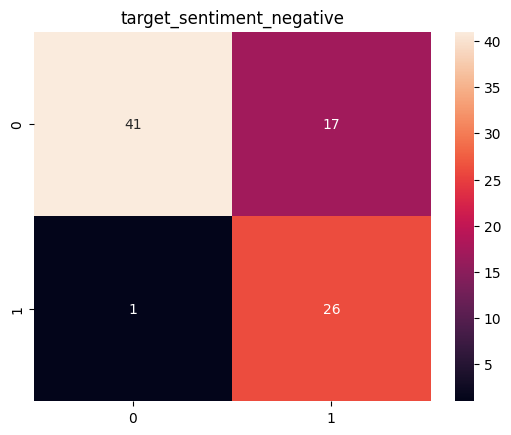

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

values = multilabel_confusion_matrix(test_labels, binary_preds)
heatmap  = sns.heatmap(values[0],annot=True)
plt.title(RETURN_VALUES[0] )

# Mostrar el heatmap
plt.show()

Podemo ver que en este caso el modelo, logra detectar muy bien las que no son de su clase. Tambien logra diferenciar las que son de su clase, pero hay 17 datos que se filtran

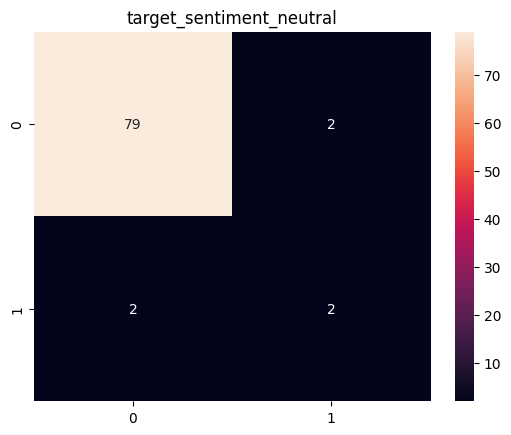

In [51]:
heatmap  = sns.heatmap(values[1],annot=True)
plt.title(RETURN_VALUES[1])

# Mostrar el heatmap
plt.show()

Podemos observar que el modelo tiene un desvalancé en los datos. Logra detectar los textos que no son de su clase pero no es confiable por el desvalance

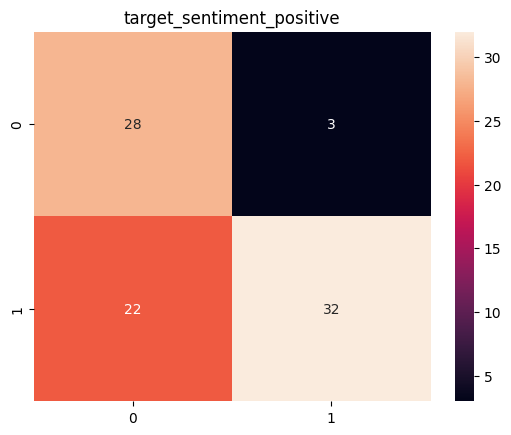

In [52]:
heatmap  = sns.heatmap(values[2],annot=True)
plt.title(RETURN_VALUES[2] )

# Mostrar el heatmap
plt.show()

El modelo logra predecir muy bien las que pertenece a su clase, pero tiene muchas falsos positivos. 

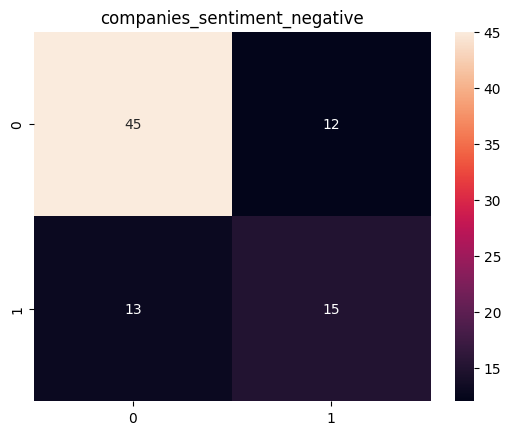

In [53]:
heatmap  = sns.heatmap(values[3],annot=True)
plt.title(RETURN_VALUES[3] )

# Mostrar el heatmap
plt.show()

El modelo detecta bien las negativas, pero siempre hay falsos positivo, no se logra detectar bien los positivos

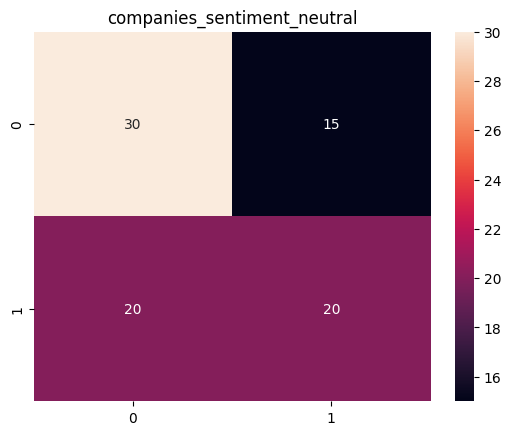

In [54]:
heatmap  = sns.heatmap(values[4],annot=True)
plt.title(RETURN_VALUES[4])

# Mostrar el heatmap
plt.show()

La clase positiva es igual a los fp. El modelo logra identificar algunos negativos

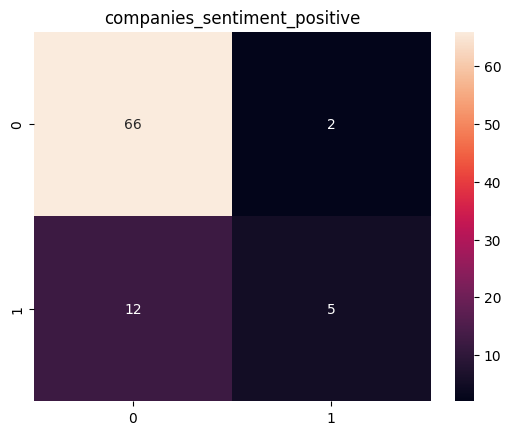

In [55]:
heatmap  = sns.heatmap(values[5],annot=True)
plt.title(RETURN_VALUES[5] )

# Mostrar el heatmap
plt.show()

Vemos que hay un desvalance en los datos, que se logra detectar bien la clase negatica y mal la clase positiva

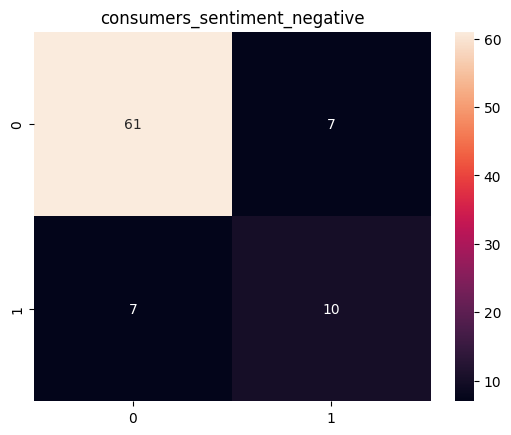

In [56]:
heatmap  = sns.heatmap(values[6],annot=True)
plt.title(RETURN_VALUES[6] )

# Mostrar el heatmap
plt.show()

LOgra detectar bien la clase negativa, hay problemas en la clase positiva

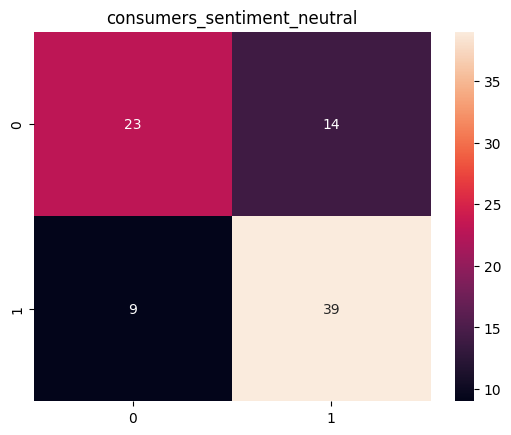

In [57]:
heatmap  = sns.heatmap(values[7],annot=True)
plt.title(RETURN_VALUES[7] )

# Mostrar el heatmap
plt.show()

Se logra detectar la clase positiva, pero siempre se equivoca en la clase negativa

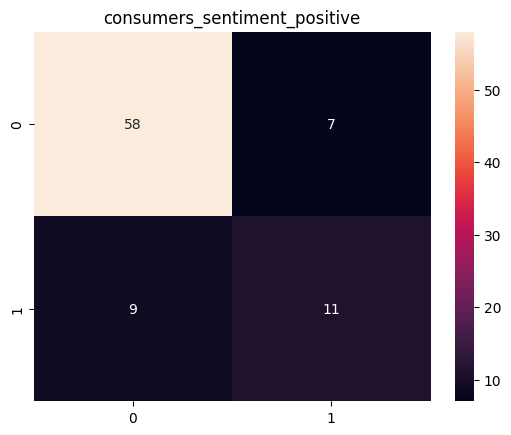

In [58]:
heatmap  = sns.heatmap(values[8],annot=True)
plt.title(RETURN_VALUES[8])

# Mostrar el heatmap
plt.show()

Bien en la clase negativa, pero muy regular para la clase positiva

### Curva ROC y AUC

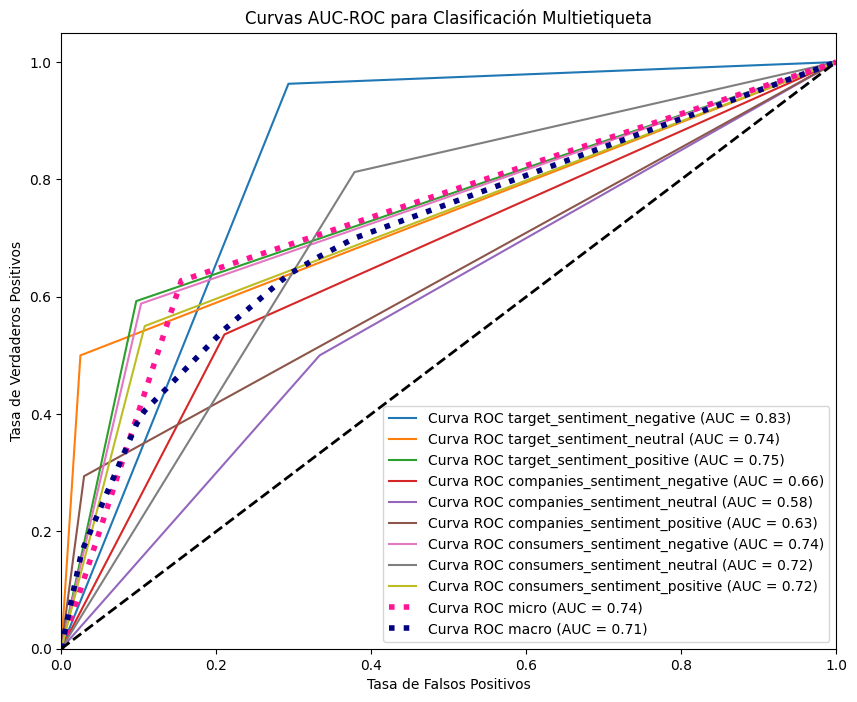

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# test_labels: etiquetas verdaderas del conjunto de prueba
# binary_preds: predicciones binarias del modelo para el conjunto de prueba
# RETURN_VALUES: nombres de las clases

# Calcular las curvas ROC y AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(RETURN_VALUES)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], binary_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC micro
fpr_micro, tpr_micro, _ = roc_curve(test_labels.ravel(), binary_preds.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Calcular la curva ROC macro
all_fpr = np.unique(np.concatenate(list(fpr.values())))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plotear las curvas ROC
plt.figure(figsize=(10, 8))

# Plotear las curvas ROC para cada clase
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Curva ROC {} (AUC = {:.2f})'.format(RETURN_VALUES[i], roc_auc[i]))

# Plotear la curva ROC micro
plt.plot(fpr_micro, tpr_micro, label='Curva ROC micro (AUC = {:.2f})'.format(roc_auc_micro), color='deeppink', linestyle=':', linewidth=4)

# Plotear la curva ROC macro
plt.plot(fpr_macro, tpr_macro, label='Curva ROC macro (AUC = {:.2f})'.format(roc_auc_macro), color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas AUC-ROC para Clasificación Multietiqueta')
plt.legend(loc="lower right")
plt.show()

Podemos ver que para la companies_sentiment_neutral se puede decir por el auc que el modelo está adivinando, esto se debe a que siempre es complejo tanto para los etiquetadores como para el modelo saber si algo es neutral. Tambien vemos que el AUC y las meétricas en general es demasiado bajo para las compañias. El paso a seguir es fortalecer el área empresarial.

En el resto, las métricas se ven bien, se puede mejorar el modelo, etiquetando más la clase para empresarial, aumentando el datset para la latinoamérica. El siguiente paso sería, hayar la incertidumbre de los nuevos datos, aplicando la filosofia del active learning.

Algo importante es entender que por la naturaleza de como se modela, siempre va  a ver un desvalance, es importante penalizar con más peso las clases positivas